# Libs

In [770]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings("ignore")

In [771]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [772]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 200
pd.set_option('max_colwidth', 1000) # tamanho das colunas para exibição do conteúdo de textos longos
np.set_printoptions(threshold=1000)

# Formatar numeros float (2 casas decimais)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
random_state=42

# Funcoes

## Utilidades

In [773]:
def print_message(msg):
    print(color.BOLD + color.BLUE + '\n' + msg + color.END)
    print(color.BOLD + color.BLUE + 50*'*' + color.END)

## Verificações dataframe

In [774]:
def checar_df(df):
    print(color.BOLD  + color.RED + 'Informações do dataframe: ' + color.END)
    df.info(verbose=True, show_counts=True)
    
    print(color.BOLD + color.RED + "\nNúmero de observacoes na base de dados: " + color.END, df.shape[0])
    print('Total de ', df.shape[1], 'Colunas: ', df.columns.values.tolist())
    
    print(color.BOLD + color.RED + "\nNúmero de valores unicos (Não inclui NaN): " + color.END)
    display(df.nunique(dropna=True).to_frame(name='Contagem Unicos').sort_index())
    
    print(color.BOLD + color.RED + "Número de valores nulos:" + color.END)
    display(df.isnull().sum().sort_values(ascending=False).to_frame(name='Contagem Nulos').sort_index())

In [775]:
# passar como parâmetro a lista de colunas para as quais se deseja obter os valores únicos existentes
def checar_val_colunas_df_lista(df, lista_colunas):
    print(color.BOLD + color.RED + "Contagem de valores unicos (inclui NaN) e apresentação da lista de valores:  \n"  
      + color.END)
    for column in lista_colunas:
        print(column, ': ', len(df[column].unique()),'valores únicos \n',
              df[column].sort_values().unique().tolist(), '\n')

In [776]:
# passar como parâmetro o número máximo de valores únicos (n_unique)
# Ex. mostrar colunas e seus valores únicos apenas quando a coluna tem acima de N valores únicos
def checar_val_colunas_df_nunique(df, n_unique):
    df_count_unique = df.nunique(dropna=False).to_frame(name='Contagem Unicos').sort_values(by='Contagem Unicos')
    lista_colunas = df_count_unique[df_count_unique['Contagem Unicos'] >= n_unique].index
    
    print(color.BOLD + color.RED + "Contagem de valores unicos (inclui NaN) e apresentação da lista de valores: "  
      + color.END)
    print(color.BOLD + color.RED + '(acima de', n_unique, 'valores únicos)\n' + color.END)
    for column in lista_colunas:
        print(column, ': ', len(df[column].unique()),'valores únicos \n',
              df[column].sort_values().unique().tolist(), '\n')

## Criar Matriz Confusão

In [777]:
def create_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    # Plotar a matriz de confusão
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['PBZ', 'BR', 'ASM'],  
            yticklabels=['PBZ', 'BR', 'ASM'])  
    plt.title('Matriz de Confusão')
    plt.xlabel('Prevista')
    plt.ylabel('Real')
    plt.show()

## Obter variaveis mais importantes

In [778]:
def get_feature_importances_RF(model, X):
    importances = model.feature_importances_ 
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances})
    
    top_10_var_predictors = feature_importances.sort_values(by='Importance', ascending=False).head(10)
    display(top_10_var_predictors)
    
    ax = feature_importances.sort_values(by='Importance', ascending=False)[0:20].plot(kind='bar', 
                                                                                      x='Feature',
                                                                                      y='Importance',
                                                                                      figsize=(15, 10))
    plt.title('Top 20 Feature Importances', fontsize=16, pad=10)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.tight_layout()  
    plt.show()
    
    return list(top_10_var_predictors['Feature'].values)

## Calcular importância das variáveis

In [779]:
# Função para calcular e armazenar a importância para um modelo
def calcular_importancia(model, X_test, y_test, model_name):
    #global feature_importance_df
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, 
                                             random_state=random_state, 
                                             n_jobs=-1)  
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    feature_importance_temp = pd.DataFrame({
        'Feature': X_test.columns,
        'Importância': importance_vals,
        'Desvio_Padrao': importance_std,
        'Modelo': model_name})
    return feature_importance_temp

In [780]:
def plotar_feature_importance(df, nome_modelo):

    dados = df[df['Modelo']==nome_modelo]
    dados = dados.sort_values(by='Importância', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(dados['Feature'], 
             dados['Importância'], 
             xerr=dados['Desvio_Padrao'], 
             color='skyblue')
    titulo = f'Importância das Features por Permutação - {nome_modelo} (Features com Importância > 0)'
    plt.title(titulo, fontsize=10)
    plt.xlabel('Importância'); plt.xticks(fontsize=8)
    plt.ylabel(''); plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()   

# Preparar planilhas metricas e feature_importance

In [843]:
# Dataframe que coleta todas as metricas de cada modelo
df_metrics = pd.DataFrame(columns=['model_name',
                                   'forma_dados', 'dados_balanceados',
                                   'test_size', 'random_seed',
                                   'accuracy',
                                   'm_precision', 'm_recall', 'm_f1_score',
                                   'w_precision', 'w_recall', 'w_f1_score',
                                   'mcc',
                                   'details', 'param', 'var_predictors'])

In [782]:
feature_importance_df = pd.DataFrame()

# Carga dados

## Carga arquivo

In [783]:
%%time
#df_fam = pd.read_csv('../dados_selecionados/df_modelo.csv',sep=',', low_memory=False)
df_fam = pd.read_csv('../dados_selecionados/df_modelo_balanceado.csv',sep=',', low_memory=False)

# checagem básica
distintos = df_fam['id_familia'].nunique()
print(f'Qtd de familias: {distintos}')

duplicados = df_fam['id_familia'].duplicated().sum()
print(f'Duplicados na coluna id_familia: {duplicados}')

# remover colunas irrelevantes
del df_fam['id_familia']

Qtd de familias: 96792
Duplicados na coluna id_familia: 0
CPU times: total: 516 ms
Wall time: 532 ms


## Checar nulls

In [784]:
print('\nQuantidade/ Percentual de campos Nulos:')

total = df_fam.isnull().sum().sort_values(ascending=False)
percent = (df_fam.isnull().sum()/df_fam.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total']>0]


Quantidade/ Percentual de campos Nulos:


,Total,Percent
dias_cadastramento,1,0.0000


In [785]:
df_fam[df_fam['dias_cadastramento'].isna()]

,uf_ibge,classf,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,ind_parc_mds_fam,qtde_pessoas,dias_cadastramento,dias_atualizacao,classe_renda,rf_idade,rf_trab_principal,rf_com_deficiencia,rf_trab_agricultura,rf_sexo,rf_curso_frequentou,rf_curso_frequenta,rf_trabalhou_semana,rf_cor_raca,rf_concluiu_curso,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,pct_nao_alfabetizados,pct_n_freq_escola,pct_freq_publica,pct_freq_particular,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_deficientes,pct_1_infancia,pct_adulto,pct_crianca_adolescente,ind_parc_mds_fam_0_1,ideb_2017_municipio
24822,52,3,2.0000,5.0000,2.0000,1.0000,0.0000,3,NaN,510,0,27,-1.0000,2,-1.0000,2,8.0000,-1.0000,2.0000,3.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3333,0.3333,0.3333,0.0000,5.5000


In [786]:
if missing_data['Total'].sum()>0:
    df_fam = df_fam.drop(index=24822)
    df_fam = df_fam.reset_index(drop=True)

In [787]:
df_fam.shape

(96791, 45)

## Verificar classes

In [789]:
t1 = df_fam['classe_renda'].value_counts(dropna='False')
t2 = df_fam['classe_renda'].value_counts(normalize=True)
t = pd.concat([t1, t2], axis=1).reset_index()
display(t.sort_values(by=['proportion'], ascending=False))

,classe_renda,count,proportion
0,2,32786,0.3387
1,0,32089,0.3315
2,1,31916,0.3297


## Converter dados

In [790]:
l_col_int = [col for col in df_fam.columns if col.startswith('cod') 
                 or col.startswith('qtd') 
                 or col.startswith('dias')
                 or col.startswith('ind')
                 or col.startswith('rf')
            ]  
#l_col_int = l_col_int + ['estrato','classf', 'classe_renda']
l_col_int = l_col_int + ['classf', 'classe_renda']

#print_message('Colunas do tipo int'); display(l_col_int)

for c in l_col_int:
    df_fam[c] = df_fam[c].astype(int)

## Verificar uniques

In [792]:
col_interesse = list(df_fam.columns.values)

#cols = ['cd_ibge','id_familia', 'vlr_renda_media_fam', 'dias_cadastramento', 'dias_atualizacao']
cols = ['dias_cadastramento', 'dias_atualizacao',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_escola',
       'pct_freq_creche', 'pct_idosos', 'pct_deficientes', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente', 'ideb_2017_municipio']
for c in cols:
    col_interesse.remove(c)

#checar_val_colunas_df_lista(df_fam, col_interesse)

# Identificar variáveis de alta multicolinearidade

## Matriz correlação

In [ ]:
#df_features[col_interesse]
df_features = df_fam.drop(columns=['classe_renda'])

mask = np.triu(np.ones_like(df_features.corr(), dtype=bool), k=1)
plt.figure(figsize=(30,12))
sns.heatmap(df_features.corr().round(1), 
            annot=True, 
            square=True, 
            fmt='.2f',
            annot_kws={'size': 10},
            cmap='coolwarm', 
            mask=mask)
plt.show()

## Corr > threshold

In [ ]:
# Obter os valores de correlação acima de um certo valor
# exceto valores da diagonal principal
corr_matrix = df_features.corr().abs()
threshold = 0.7
high_corr_pairs = np.where((corr_matrix > threshold) 
                           & (np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))

# Obter os pares de colunas com correlação > threshold
high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                  for x, y in zip(*high_corr_pairs)]

for col1, col2, corr_value in high_corr_list:
    print(f"Colunas: {col1} e {col2}, Correlação: {corr_value:.2f}")

## Excluir colunas de alta correlação

In [793]:
# acima 0.79
col_high_corr = ['ind_parc_mds_fam', 'pct_deficientes', 'rf_trabalhou_semana',
                'pct_adulto_nunca_freq_escola', 'pct_crianca_adolescente']

# ACIMA 0.70
#col_high_corr = ['ind_parc_mds_fam', 'pct_deficientes', 'rf_trabalhou_semana',
#                'pct_adulto_nunca_freq_escola', 'pct_crianca_adolescente',
#                'rf_trab_agricultura','pct_idosos']

for c in col_high_corr:
    del df_fam[c]

# Preparação dos dados

## Manter sem preparação

In [795]:
# nao fazer nada
l_col_cat_bin = ['rf_com_deficiencia', 'rf_sexo', 'ind_parc_mds_fam_0_1']
df_fam[l_col_cat_bin].sample(10).T

,42589,63945,65263,43062,83941,71018,11556,68659,15701,76880
rf_com_deficiencia,2,2,2,2,2,2,2,1,2,2
rf_sexo,1,2,2,2,2,2,2,1,1,2
ind_parc_mds_fam_0_1,0,0,0,0,0,0,0,0,0,0


## Padronização atributos numericos

In [796]:
l_col_num = ['qtd_comodos_domic_fam', 
             'dias_cadastramento', 
             'dias_atualizacao', 
             'qtde_pessoas',
             'rf_idade',
            'ideb_2017_municipio']

l_col_num_scaled = ['qtd_comodos_domic_fam_scaled', 
                    'dias_cadastramento_scaled', 
                    'dias_atualizacao_scaled',
                    'qtde_pessoas_scaled',
                    'rf_idade_scaled',
                    'ideb_2017_municipio_scaled']

In [797]:
scaler = StandardScaler()
#df_fam[l_col_num] = scaler.fit_transform(df_fam[l_col_num])

df_fam_scaled = pd.DataFrame(scaler.fit_transform(df_fam[l_col_num]),
                             columns=[f'{col}_scaled' for col in l_col_num])

df_fam = pd.concat([df_fam, df_fam_scaled], axis=1)
print('Atributos normalizados:\n', df_fam_scaled.columns.values)

for c in l_col_num:
    del df_fam[c]

Atributos normalizados:
 ['qtd_comodos_domic_fam_scaled' 'dias_cadastramento_scaled'
 'dias_atualizacao_scaled' 'qtde_pessoas_scaled' 'rf_idade_scaled'
 'ideb_2017_municipio_scaled']


In [798]:
#col = l_col_num #+ l_col_num_scaled 
#df_bkp.loc[96791:96792,:][col].T
#df_bkp.loc[96791:96792,:][col].T

## Padronização atributos categoricos numericos

In [799]:
l_col_cat_num = ['classf', 
                 'cod_local_domic_fam', 'cod_material_piso_fam',
                 'cod_iluminacao_domic_fam', 'rf_trab_principal',
                 'rf_trab_agricultura',
                 'rf_curso_frequentou',
                 'rf_curso_frequenta', 'rf_cor_raca',
                 'rf_concluiu_curso']

l_col_cat_num_scaled = ['classf_scaled', 'cod_local_domic_fam_scaled',
                        'cod_material_piso_fam_scaled', 'cod_iluminacao_domic_fam_scaled',
                        'rf_trab_principal_scaled', 
                        'rf_trab_agricultura_scaled',
                        'rf_curso_frequentou_scaled', 'rf_curso_frequenta_scaled',
                        'rf_cor_raca_scaled', 'rf_concluiu_curso_scaled']

#df_fam[l_col_cat_num] = scaler.fit_transform(df_fam[l_col_cat_num])

df_fam_scaled2 = pd.DataFrame(scaler.fit_transform(df_fam[l_col_cat_num]),
                             columns=[f'{col}_scaled' for col in l_col_cat_num])
df_fam = pd.concat([df_fam, df_fam_scaled2], axis=1)
print('Atributos normalizados:\n', df_fam_scaled2.columns.values)
for c in l_col_cat_num:
    del df_fam[c]

Atributos normalizados:
 ['classf_scaled' 'cod_local_domic_fam_scaled'
 'cod_material_piso_fam_scaled' 'cod_iluminacao_domic_fam_scaled'
 'rf_trab_principal_scaled' 'rf_curso_frequentou_scaled'
 'rf_curso_frequenta_scaled' 'rf_cor_raca_scaled'
 'rf_concluiu_curso_scaled']


## Aplicação One Hot Encoding

In [800]:
l_col_cat = ['uf_ibge']
label_encoders_2 = {}
label_mappings_2 = {}

encoder_2 = OneHotEncoder(sparse=False)

for col in l_col_cat:
    one_hot_encoded = encoder_2.fit_transform(df_fam[[col]])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=[f'{col}_{category}' for category in encoder_2.categories_[0]])
    df_fam = pd.concat([df_fam, one_hot_encoded_df], axis=1)
    label_encoders_2[col] = encoder_2
    label_mappings_2[col] = dict(zip(encoder_2.categories_[0], range(len(encoder_2.categories_[0]))))

for col in l_col_cat:
    del df_fam[col]

## Seleção variáveis independentes

### Definir conjuntos preditoras e target

In [801]:
X = df_fam.copy()
del X['classe_renda']
y = df_fam['classe_renda']

In [802]:
X.columns

Index(['rf_com_deficiencia', 'rf_sexo', 'pct_extrativista',
       'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_escolar_nunca_freq_escola', 'pct_freq_creche', 'pct_1_infancia',
       'pct_adulto', 'ind_parc_mds_fam_0_1', 'qtd_comodos_domic_fam_scaled',
       'dias_cadastramento_scaled', 'dias_atualizacao_scaled',
       'qtde_pessoas_scaled', 'rf_idade_scaled', 'ideb_2017_municipio_scaled',
       'classf_scaled', 'cod_local_domic_fam_scaled',
       'cod_material_piso_fam_scaled', 'cod_iluminacao_domic_fam_scaled',
       'rf_trab_principal_scaled', 'rf_curso_frequentou_scaled',
       'rf_curso_frequenta_scaled', 'rf_cor_raca_scaled',


### Verificações

In [803]:
print('Shape do df:', X.shape)
print('Tipos existentes no dataframe X:', X.dtypes.unique())

Shape do df: (96791, 63)
Tipos existentes no dataframe X: [dtype('int32') dtype('float64')]


In [804]:
#X.info()
#X.isnull().sum()

# Geração modelos

## Parametros

In [842]:
# dados que serao gravados na planilha
forma_dados = 'l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot'
dados_balanceados='Sim' 
test_size=0.2 
random_state=42
cv=3
details=f'df_balanceado, Pipeline 4 modelos, GridSearchCV com CV={cv}'
#details='df_fam ja balanceado, sem usar stratify'
var_predictors = 'todas, exceto as de correlacao acima 0.71'

## Divisão dados treino e testes

In [807]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_state)
                                                    #stratify=y)

In [ ]:
#X_train, X_test, y_train, y_test= train_test_split(X_balanced, 
#                                                   y_balanced, 
#                                                   test_size=0.2, 
#                                                   random_state=random_state)

## Definir pipeline de modelos

In [831]:
# Definir os modelos e os parâmetros
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=random_state),
        'param_grid': {
            'classifier__max_depth': [7, 9, 12],
            'classifier__min_samples_split': [2, 5, 10] }},
    
    'RandomForest': {
        'model': RandomForestClassifier(random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [50, 200, 300],
            'classifier__max_depth': [None, 7, 10, 20], 
            'classifier__criterion': ['gini', 'entropy'] 
        }},
    
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', 
                               num_class=3, 
                               random_state=random_state),
        'param_grid': {
            'classifier__n_estimators': [100, 300],
            'classifier__max_depth': [3, 5, 10],
            'classifier__learning_rate': [0.1, 0.05] }},
    
    'CatBoost': {
        'model': CatBoostClassifier(silent=True, 
                                    random_state=random_state),
        'param_grid': {
            'classifier__iterations': [100, 250, 500],
            'classifier__depth': [3, 5, 6, 7],
            'classifier__learning_rate': [0.1, 0.05],
            'classifier__loss_function': ['MultiClass', 'MultiClassOneVsAll']
            }}
}

## Executar e Selecionar melhor modelo

In [832]:
%%time
best_models = {}
best_params = {}

for model_name, model_info in models.items():
    pipeline = Pipeline([
        #('scaler', StandardScaler()),
        ('classifier', model_info['model'])])
    
    # GridSearchCV
    grid_search = GridSearchCV(pipeline, 
                               model_info['param_grid'], 
                               cv=cv, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Armazenar o melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Melhores hiperparâmetros para DecisionTree: {'classifier__max_depth': 12, 'classifier__min_samples_split': 2}
Melhores hiperparâmetros para RandomForest: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__n_estimators': 200}
Melhores hiperparâmetros para XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Melhores hiperparâmetros para CatBoost: {'classifier__depth': 7, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1, 'classifier__loss_function': 'MultiClass'}
CPU times: total: 2min 15s
Wall time: 16min 29s


## Avaliar modelos

### Medidas desempenho

In [844]:
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    
    acc_score = accuracy_score(y_test, y_pred)
    m_precision = precision_score(y_test, y_pred, average='macro')
    m_recall = recall_score(y_test, y_pred, average='macro')
    m_f1 = f1_score(y_test, y_pred, average='macro')
    w_precision = precision_score(y_test, y_pred, average='weighted')
    w_recall = recall_score(y_test, y_pred, average='weighted')
    w_f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)

    result = {
    'model_name': model_name,
    'forma_dados':forma_dados,
    'dados_balanceados': dados_balanceados,    
    'test_size': test_size,
    'random_seed': random_state,
    'accuracy': f'{acc_score:.6f}', 
    'm_precision': f'{m_precision:.6f}', 
    'm_recall': f'{m_recall:.6f}', 
    'm_f1_score': f'{m_f1:.6f}',
    'w_precision': f'{w_precision:.6f}', 
    'w_recall': f'{w_recall:.6f}', 
    'w_f1_score': f'{w_f1:.6f}',
    'mcc': f'{mcc:.6f}',
    'details': details,
    'param': best_params[model_name],
    'var_predictors':var_predictors,
    }  

    df_metrics = pd.concat([df_metrics, 
                            pd.DataFrame([result])], 
                           ignore_index=True)

In [845]:
df_metrics.sort_values(by='accuracy', ascending=False).head(5)
#df_metrics[df_metrics['model_name']=='XGBoost'] 
#df_metrics[df_metrics['model_name']=='CatBoost'] 
#df_metrics[df_metrics['model_name']=='RandomForest'] 

,model_name,forma_dados,dados_balanceados,test_size,random_seed,accuracy,m_precision,m_recall,m_f1_score,w_precision,w_recall,w_f1_score,mcc,details,param,var_predictors
3,CatBoost,"l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot",Sim,0.2000,42,0.739863,0.739298,0.740353,0.739633,0.739041,0.739863,0.739259,0.610003,"df_balanceado, Pipeline 4 modelos, GridSearchCV com CV=3","{'classifier__depth': 7, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1, 'classifier__loss_function': 'MultiClass'}","todas, exceto as de correlacao acima 0.71"
2,XGBoost,"l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot",Sim,0.2000,42,0.737590,0.736701,0.738141,0.737066,0.736465,0.737590,0.736673,0.606757,"df_balanceado, Pipeline 4 modelos, GridSearchCV com CV=3","{'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}","todas, exceto as de correlacao acima 0.71"
1,RandomForest,"l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot",Sim,0.2000,42,0.730565,0.729803,0.731133,0.730041,0.729578,0.730565,0.729645,0.596289,"df_balanceado, Pipeline 4 modelos, GridSearchCV com CV=3","{'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__n_estimators': 200}","todas, exceto as de correlacao acima 0.71"
0,DecisionTree,"l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot",Sim,0.2000,42,0.698693,0.699152,0.699471,0.697786,0.698978,0.698693,0.697318,0.549479,"df_balanceado, Pipeline 4 modelos, GridSearchCV com CV=3","{'classifier__max_depth': 12, 'classifier__min_samples_split': 2}","todas, exceto as de correlacao acima 0.71"


### Salvar a planilha de metricas

In [846]:
# salvar as metricas
df_metrics.to_csv('../dados_metricas/df_metrics_final.csv', encoding='UTF-8',  sep='|',  index=False)

### Matriz Confusao


Modelo: DecisionTree
**************************************************


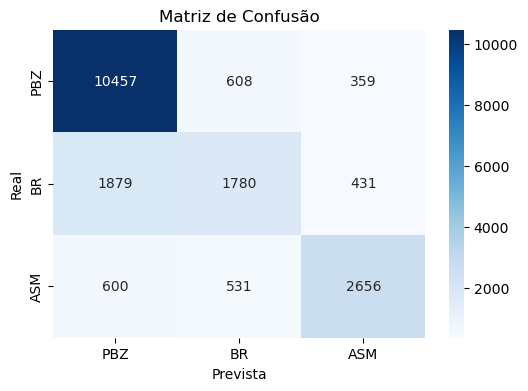


Modelo: RandomForest
**************************************************


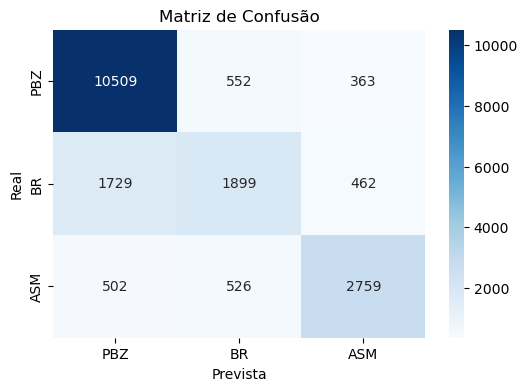


Modelo: XGBoost
**************************************************


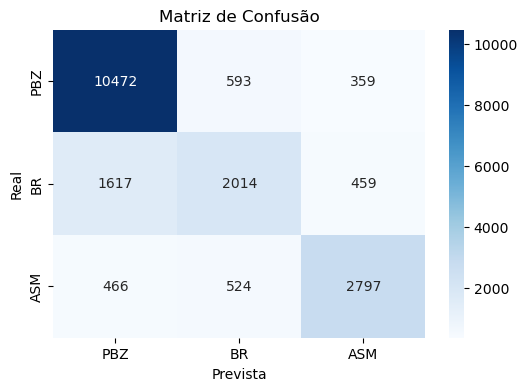


Modelo: CatBoost
**************************************************


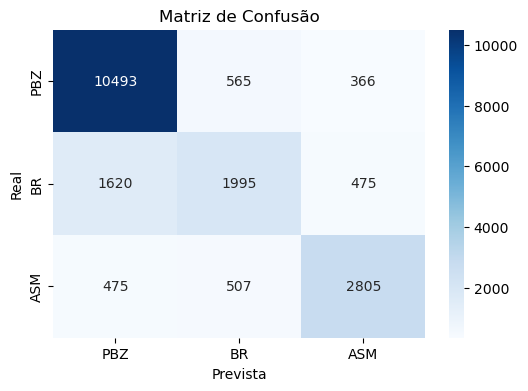

In [181]:
for model_name, model in best_models.items():
    msg = f'Modelo: {model_name}'
    print_message(msg)
    y_pred = model.predict(X_test)
    create_confusion_matrix(y_test, y_pred)

### Analise importancia features

In [847]:
%%time
# Calcular importâncias para cada modelo
all_importances = []
all_importances.append(calcular_importancia(best_models['DecisionTree'], X_test, y_test, 'DecisionTree'))
all_importances.append(calcular_importancia(best_models['RandomForest'], X_test, y_test, 'RandomForest'))
all_importances.append(calcular_importancia(best_models['XGBoost'], X_test, y_test, 'XGBoost'))
all_importances.append(calcular_importancia(best_models['CatBoost'], X_test, y_test, 'CatBoost'))

# Concatenar todos os resultados 
feature_importance_temp = pd.concat(all_importances, ignore_index=True)

# juntar outras colunas 
feature_importance_temp['forma_dados'] = forma_dados
feature_importance_temp['dados_balanceados']= dados_balanceados
feature_importance_temp['details'] = details
feature_importance_temp['var_predictors'] = var_predictors

feature_importance_df = pd.concat([feature_importance_df, feature_importance_temp], ignore_index=True)
feature_importance_df = feature_importance_df[feature_importance_df['Importância'] > 0.0]

modelos = list(feature_importance_df['Modelo'].unique())

CPU times: total: 1min 39s
Wall time: 4min 20s


### Salvar a planilha de features

In [848]:
feature_importance_df.to_csv('../dados_metricas/df_feature_importance.csv', encoding='UTF-8',  sep='|',  index=False)

### Exibir plots de feature importance

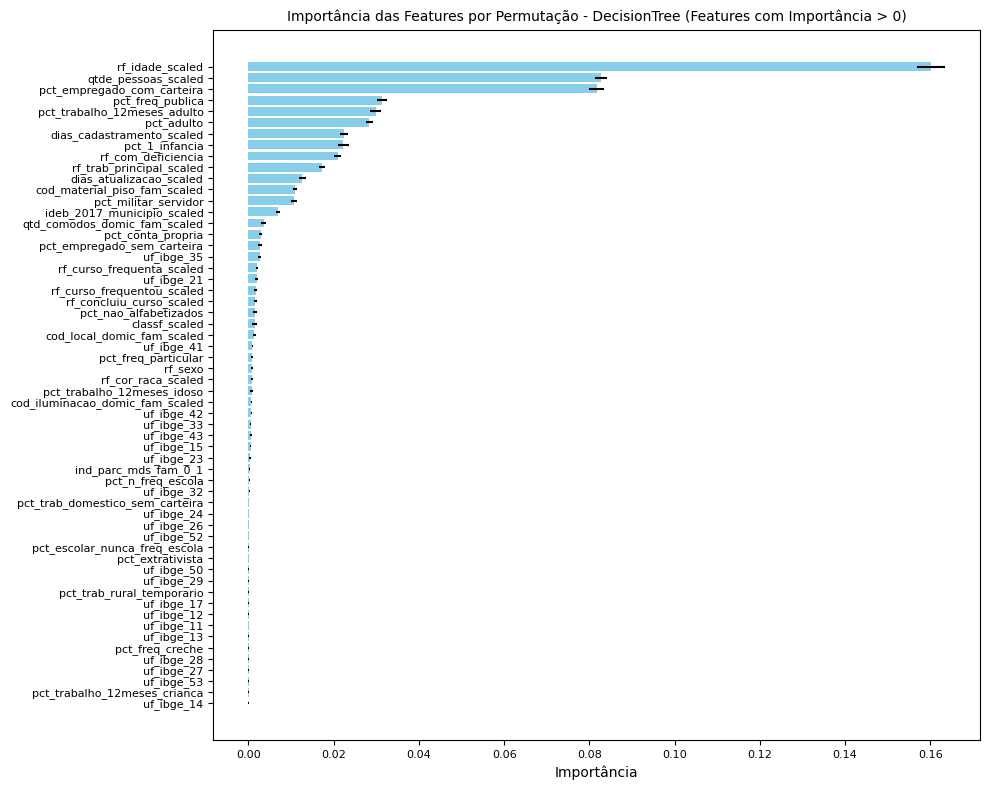

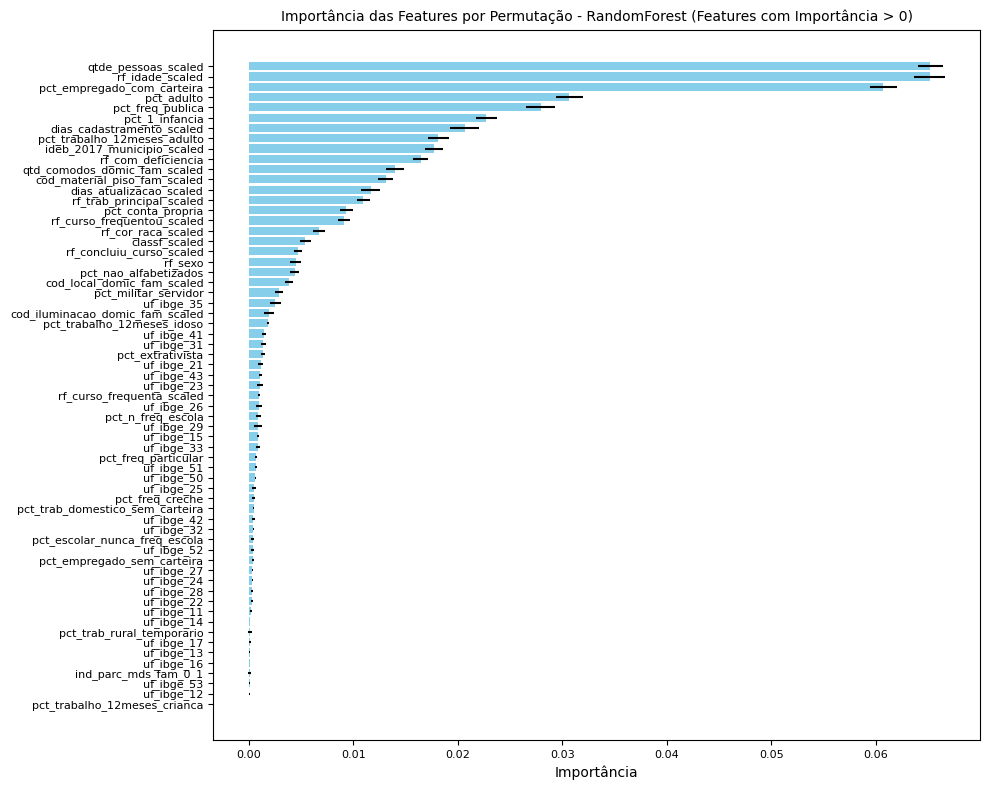

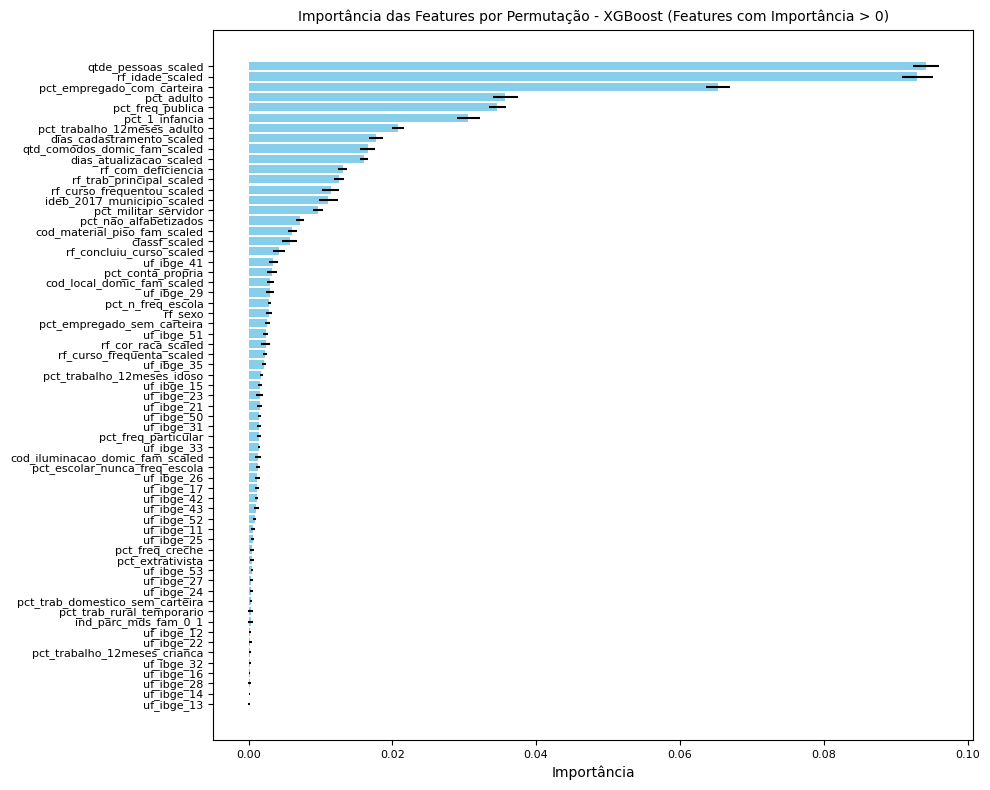

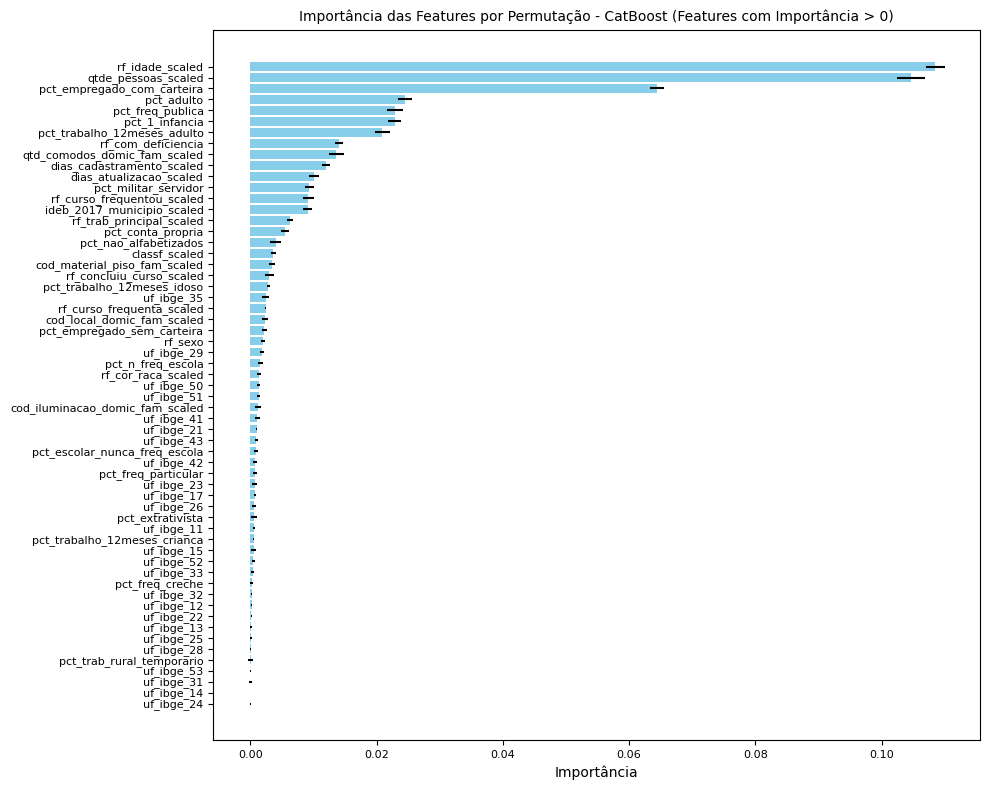

In [50]:
# selecionar uma condição ja que a planilha traz dados de todas as execucoes
selecao = feature_importance_df[feature_importance_df['dados_balanceados']=='Sim']

for m in modelos:
    plotar_feature_importance(selecao, m)

# Balanceamento

## Informações

,classe_renda,count,proportion
0,0,56373,0.5842
1,1,20597,0.2134
2,2,19532,0.2024


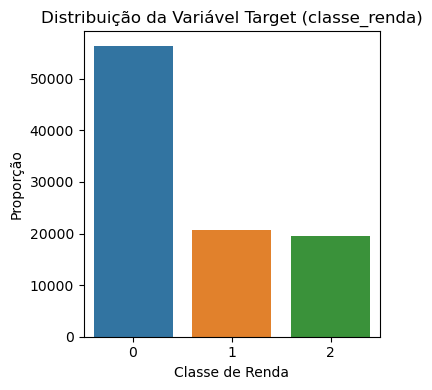

In [575]:
t1 = df_fam['classe_renda'].value_counts()
t2 = df_fam['classe_renda'].value_counts(normalize=True)
t = pd.concat([t1, t2], axis=1).reset_index()
display(t.sort_values(by=['proportion'], ascending=False))

plt.figure(figsize=(4, 4))
sns.barplot(data=t, x='classe_renda', y='count')
plt.title('Distribuição da Variável Target (classe_renda)')
plt.xlabel('Classe de Renda'); plt.ylabel('Proporção'); plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Balanceando as classes

In [576]:
df_fam.shape

(96502, 66)

In [651]:
# Primeiro, aplica-se o SMOTE para criar amostras sintéticas das classes minoritárias
# Depois, faz-se undersampling para reduzir a classe majoritária a um tamanho mais equilibrado
#over = SMOTE(sampling_strategy={1.0: 35000, 2.0: 35000})  # Aumenta as classes 1 e 2 para 35k cada
#under = RandomUnderSampler(sampling_strategy={0.0: 40000})  # Reduz a classe 0 para 40k
over = SMOTE(sampling_strategy={1.0: 35000, 2.0: 35000})  # Aumenta as classes 1 e 2 para 35k cada
under = RandomUnderSampler(sampling_strategy={0.0: 40000})  # Reduz a classe 0 para 40k

# Criar um pipeline que aplica SMOTE e depois o undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])
# Aplicar o balanceamento ao conjunto de dados
X_balanced, y_balanced = pipeline.fit_resample(X, y)
print('X_balanced:', X_balanced.shape)
print('y_balanced', y_balanced.shape)

# Verificar a nova distribuição das classes
balanced_distribution = pd.Series(y_balanced).value_counts()
print("Distribuição da variável target 'classe_renda' após o balanceamento:")
print(balanced_distribution)

X_balanced: (110000, 65)
y_balanced (110000,)
Distribuição da variável target 'classe_renda' após o balanceamento:
classe_renda
0    40000
1    35000
2    35000
Name: count, dtype: int64


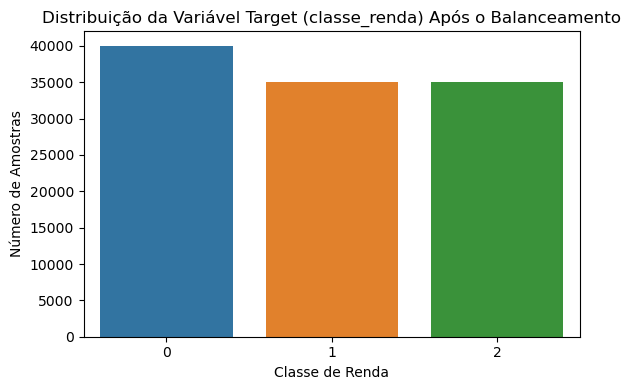

In [578]:
plt.figure(figsize=(6, 4))
sns.barplot(x=balanced_distribution.index, y=balanced_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda) Após o Balanceamento')
plt.xlabel('Classe de Renda')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Divisão dados treino e testes

In [148]:
X_train, X_test, y_train, y_test= train_test_split(X_balanced, 
                                                   y_balanced, 
                                                   test_size=0.2, 
                                                   random_state=random_state)

In [ ]:
# executar a partir do item 7.3 - Geracao de modelos/ Definir pipeline

# Execucao de um modelo especifico

## Parametros

In [849]:
model_name='Random Forest'
forma_dados = 'l_col_cat_bin, l_col_num_scaled, l_col_cat_num_scaled, UF one-hot'
dados_balanceados='Sim' 

test_size=0.2
random_seed=42

n_estimators = 200
criterion= 'gini' 
max_depth = 20

details='df_fam ja balanceado, sem stratify'
var_predictors = 'todas, exceto as de correlacao acima 0.71'

## Divisao treino e testes

In [653]:
#X_train, X_test, y_train, y_test= train_test_split(X_balanced, 
#                                                   y_balanced, 
#                                                   test_size=0.2, 
#                                                   random_state=random_state)

In [850]:
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   test_size=0.2, 
                                                   random_state=random_state)

## Treinar o modelo

In [851]:
%%time
model = RandomForestClassifier(n_estimators=n_estimators, 
                               criterion=criterion,
                               max_depth=max_depth,
                               random_state=42,
                               )

model.fit(X_train, y_train)
params = model.get_params()
predictions = model.predict(X_test)

CPU times: total: 24.4 s
Wall time: 24.6 s


In [852]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

acc_score = accuracy_score(y_test, y_pred)
print("Accuracy:", acc_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7305645952786818
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75      6371
           1       0.66      0.63      0.65      6527
           2       0.80      0.79      0.79      6461

    accuracy                           0.73     19359
   macro avg       0.73      0.73      0.73     19359
weighted avg       0.73      0.73      0.73     19359



## Avaliar o modelo

In [656]:
# dados balanceados pelo SMOTE
#report_df = pd.DataFrame(report).transpose()
#display(report_df)

,precision,recall,f1-score,support
0,0.8073,0.8678,0.8364,8041.0000
1,0.7753,0.7211,0.7472,6977.0000
2,0.8579,0.8437,0.8507,6982.0000
accuracy,0.8136,0.8136,0.8136,0.8136
macro avg,0.8135,0.8109,0.8115,22000.0000
weighted avg,0.8132,0.8136,0.8127,22000.0000


In [701]:
# dataframe já balanceado
report_df = pd.DataFrame(report).transpose()
display(report_df)

,precision,recall,f1-score,support
0,0.7326,0.7743,0.7528,6371.0000
1,0.6638,0.6302,0.6465,6527.0000
2,0.7950,0.7911,0.7930,6461.0000
accuracy,0.7313,0.7313,0.7313,0.7313
macro avg,0.7305,0.7318,0.7308,19359.0000
weighted avg,0.7302,0.7313,0.7304,19359.0000


In [702]:
acc_score = accuracy_score(y_test, y_pred)
m_precision = precision_score(y_test, y_pred, average='macro')
m_recall = recall_score(y_test, y_pred, average='macro')
m_f1 = f1_score(y_test, y_pred, average='macro')
w_precision = precision_score(y_test, y_pred, average='weighted')
w_recall = recall_score(y_test, y_pred, average='weighted')
w_f1 = f1_score(y_test, y_pred, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred)

print(acc_score)
print(m_precision)
print(m_recall)
print(m_f1)
print(w_precision)
print(w_recall)
print(w_f1)
print(mcc)


0.7312877731287774
0.7304526807724873
0.731831814828157
0.730801965291906
0.7302157402013072
0.7312877731287774
0.7304122468196276
0.5972894718499759


## Matriz Confusão

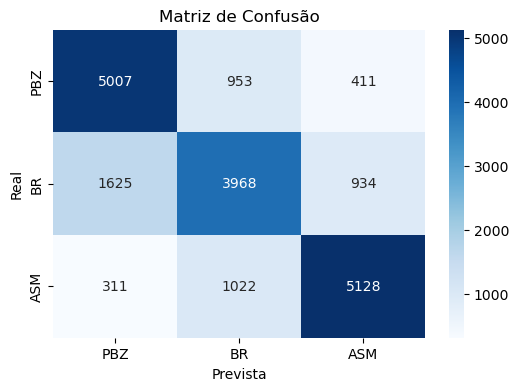

In [737]:
create_confusion_matrix(y_test, y_pred)

## Features mais importantes

,Feature,Importance
26,rf_idade_scaled,0.0966
18,pct_idosos,0.0697
25,qtde_pessoas_scaled,0.0643
23,dias_cadastramento_scaled,0.0638
24,dias_atualizacao_scaled,0.0580
20,pct_adulto,0.0552
27,ideb_2017_municipio_scaled,0.0518
6,pct_empregado_com_carteira,0.0474
14,pct_freq_publica,0.0359
22,qtd_comodos_domic_fam_scaled,0.0359


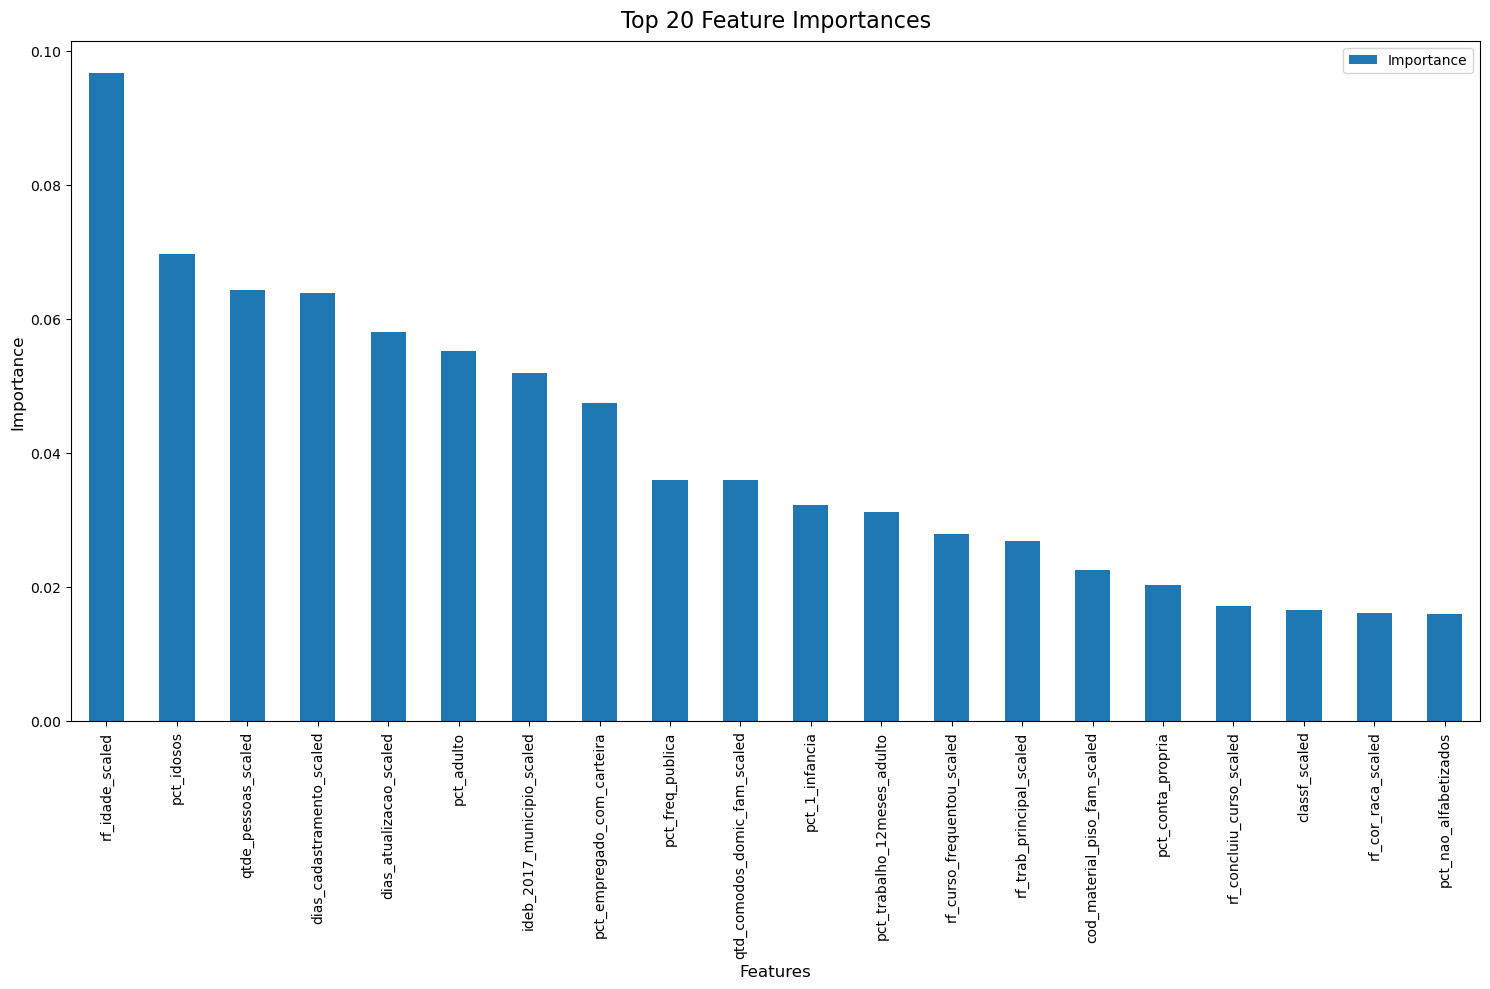

In [153]:
top_10_var_predictors = get_feature_importances_RF(model, X)

# Performance antes e após o balanceamento

## Cenario 1 - var_numericas normalizadas 

In [134]:
#df_metrics[df_metrics['dados_balanceados']=='Sim']
tmp2 = df_metrics[df_metrics['dados_balanceados']=='Sim'].groupby(['model_name', 'm_f1_score'])['accuracy'].max().reset_index()
tmp2.columns = ['model_name', 'f1_score_bal', 'accuracy_bal']
tmp1 = df_metrics[df_metrics['dados_balanceados']=='Não'].groupby(['model_name', 'm_f1_score'])['accuracy'].max().reset_index()
tmp1.columns = ['model_name', 'f1_score_nao_bal', 'accuracy_nao_bal']
tmp = pd.merge(tmp1, tmp2, on='model_name', how='inner')
tmp = tmp[['model_name', 'accuracy_nao_bal', 'accuracy_bal', 'f1_score_nao_bal', 'f1_score_bal']]
tmp

,model_name,accuracy_nao_bal,accuracy_bal,f1_score_nao_bal,f1_score_bal
0,CatBoost,0.791617,0.796636,0.727991,0.792857
1,DecisionTree,0.771566,0.726136,0.700251,0.725724
2,RandomForest,0.786229,0.807591,0.719108,0.805147
3,XGBoost,0.792342,0.795727,0.729877,0.791975


In [216]:
top_10_features_per_model_antes = {}
top_10_features_per_model_depois = {}

for modelo in feature_importance_df['Modelo'].unique():
    
    tmp1 = feature_importance_df[
        (feature_importance_df['dados_balanceados'] == 'Não') & 
        (feature_importance_df['Modelo'] == modelo)]
    top_10_antes = tmp1[['Modelo','Feature', 'Importância']].sort_values(by='Importância', ascending=False).head(10)
    top_10_features_per_model_antes[modelo] = top_10_antes

    tmp2 = feature_importance_df[
        (feature_importance_df['dados_balanceados'] == 'Sim') & 
        (feature_importance_df['Modelo'] == modelo)]
    top_10_depois = tmp2[['Modelo','Feature', 'Importância']].sort_values(by='Importância', ascending=False).head(10)
    top_10_features_per_model_depois[modelo] = top_10_depois

In [217]:
top_antes = pd.concat(top_10_features_per_model_antes.values(), ignore_index=True)
#top_antes = top_antes.sort_values(by='Importância', ascending=False)
top_antes.columns=['Modelo', 'Feature_antes', 'Importancia_antes']

top_depois = pd.concat(top_10_features_per_model_depois.values(), ignore_index=True)
top_depois.columns=['Modelo_2', 'Feature_depois', 'Importancia_depois']

top = pd.concat([top_antes, top_depois], axis=1)
del top['Modelo_2']

top

,Modelo,Feature_antes,Importancia_antes,Feature_depois,Importancia_depois
0,DecisionTree,pct_idosos,0.1828,pct_idosos,0.1744
1,DecisionTree,pct_empregado_com_carteira,0.0680,qtde_pessoas_scaled,0.0895
2,DecisionTree,qtde_pessoas_scaled,0.0399,pct_empregado_com_carteira,0.0746
3,DecisionTree,pct_adulto,0.0349,pct_adulto,0.0599
4,DecisionTree,pct_trabalho_12meses_adulto,0.0206,rf_com_deficiencia,0.0224
5,DecisionTree,rf_com_deficiencia,0.0122,pct_trabalho_12meses_adulto,0.0215
6,DecisionTree,rf_idade_scaled,0.0111,uf_ibge,0.0148
7,DecisionTree,pct_militar_servidor,0.0108,pct_militar_servidor,0.0117
8,DecisionTree,cod_material_piso_fam,0.0106,rf_idade_scaled,0.0115
9,DecisionTree,uf_ibge,0.0069,pct_1_infancia,0.0090
